<a href="https://colab.research.google.com/github/jiangwei221/useful_scripts/blob/master/random_rotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Uniform) Random Rotations

## Daniel Rebain



In [1]:
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.special import erfc, erfcinv
import matplotlib.pyplot as plt

The simple method computes a sample from a uniform distribution on the surface of a 4D sphere by normalizing a sample from a 4D unit Gaussian distribution.

In [2]:
def uniform_rot(N):
  """A simple approach using Gaussians
  
  See: Shoemake, K. (1992). UNIFORM RANDOM ROTATIONS. 
  Graphics Gems III (IBM Version), 124–132. 
  doi:10.1016/b978-0-08-050755-2.50036-1 
  """
  q = np.random.randn(N, 4)
  q /= np.linalg.norm(q, axis=-1, keepdims=True)
  return q

The fast method works by composing a random rotation around the z-axis with a rotation that orients the z-axis in a random direction.

This avoids having to accurately sample a Gaussian, which is somewhat expensive.

In [3]:
def fast_uniform_rot(N):
  """The fast method as described in: 

  Arvo, J. (1992). FAST RANDOM ROTATION MATRICES. 
  Graphics Gems III (IBM Version), 117–120. 
  doi:10.1016/b978-0-08-050755-2.50034-8 
  """
  theta = 2 * np.pi * np.random.rand(N)
  phi = 2 * np.pi * np.random.rand(N)
  z = np.random.rand(N)
  v0 = np.cos(phi) * np.sqrt(z)
  v1 = np.sin(phi) * np.sqrt(z)
  v2 = np.sqrt(1 - z)
  V = np.stack([v0, v1, v2], axis=1)
  R = np.stack([np.cos(theta), np.sin(theta), np.zeros((N, )),
                -np.sin(theta), np.cos(theta), np.zeros((N, )),
                np.zeros((N, )), np.zeros((N, )), np.ones((N, ))], axis=1)
  R = np.reshape(R, (-1, 3, 3))
  M = (2 * V[:, None] * V[:, :, None] - np.eye(3)[None]) @ R
  return Rotation.from_matrix(M).as_quat()

An incorrect method based on uniform random Euler angles.

In [4]:
def euler_uniform_rot(N):
  """Incorrect! do not use."""
  angles = 2.0 * np.pi * np.random.rand(N, 3)
  return Rotation.from_euler("XYZ", angles).as_quat()

We can empirically compare distributions to see which are actually correct.

In [5]:
def quat_angle(q):
  return 2.0 * np.arccos(np.abs(q[..., -1]))

def compare_distributions(sampler0, sampler1):
  """This draws samples from two quaternion distributions and compares
  the mean squared error between their histograms.
  """
  hist0 = {}
  hist1 = {}

  N = 10**6
  samples0 = Rotation.from_quat(sampler0(N)).as_rotvec() * 5 / np.pi
  samples1 = Rotation.from_quat(sampler1(N)).as_rotvec() * 5 / np.pi

  for s in samples0:
    bin = tuple(s.astype(np.int32))
    if bin in hist0:
      hist0[bin] += 1
    else:
      hist0[bin] = 0

  for s in samples1:
    bin = tuple(s.astype(np.int32))
    if bin in hist1:
      hist1[bin] += 1
    else:
      hist1[bin] = 0

  bins = set(hist0.keys()).union(hist1.keys())
  errs = []
  for bin in bins:
    errs.append((hist1.get(bin, 0) - hist0.get(bin, 0))**2)

  return np.sum(errs) / N**2

In [6]:
print("fast_uniform_rot vs uniform_rot:        (Expected: match)    {:08.6f}".format(compare_distributions(fast_uniform_rot, uniform_rot)))
print("fast_uniform_rot vs euler_uniform_rot:  (Expected: no match) {:08.6f}".format(compare_distributions(fast_uniform_rot, euler_uniform_rot)))
print("uniform_rot vs euler_uniform_rot:       (Expected: no match) {:08.6f}".format(compare_distributions(uniform_rot, euler_uniform_rot)))

print("euler_uniform_rot vs euler_uniform_rot: (Expected: match)    {:08.6f}".format(compare_distributions(euler_uniform_rot, euler_uniform_rot)))
print("uniform_rot vs uniform_rot:             (Expected: match)    {:08.6f}".format(compare_distributions(uniform_rot, uniform_rot)))
print("fast_uniform_rot vs fast_uniform_rot:   (Expected: match)    {:08.6f}".format(compare_distributions(fast_uniform_rot, fast_uniform_rot)))

fast_uniform_rot vs uniform_rot:        (Expected: match)    0.000002
fast_uniform_rot vs euler_uniform_rot:  (Expected: no match) 0.001652
uniform_rot vs euler_uniform_rot:       (Expected: no match) 0.001649
euler_uniform_rot vs euler_uniform_rot: (Expected: match)    0.000002
uniform_rot vs uniform_rot:             (Expected: match)    0.000002
fast_uniform_rot vs fast_uniform_rot:   (Expected: match)    0.000002


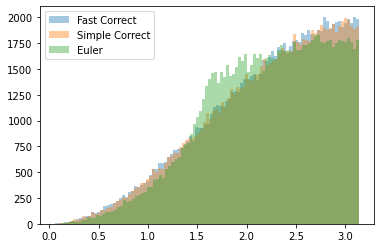

In [7]:
plt.hist(quat_angle(fast_uniform_rot(100000)), bins=100, alpha=0.4, label="Fast Correct")
plt.hist(quat_angle(uniform_rot(100000)), bins=100, alpha=0.4, label="Simple Correct")
plt.hist(quat_angle(euler_uniform_rot(100000)), bins=100, alpha=0.4, label="Euler")
plt.legend()

## Limiting Angle

The simplest approach is to simply discard samples above the angle limit, though this is very inefficient for small angles.

In [8]:
def rejection_sample(sampler, N, limit):
  """Use a standard uniform sampler and reject angles > limit"""
  limited_samples = np.zeros((0, 4))
  batch = N
  while limited_samples.shape[0] < N:
    new_samples = sampler(batch)
    angles = quat_angle(new_samples)
    valid = new_samples[angles <= limit]
    limited_samples = np.concatenate([limited_samples, valid], axis=0)
    remaining = N - limited_samples.shape[0]
    batch = int(2 * remaining * batch / (valid.shape[0] + 1))

  return limited_samples[:N]

We can also adapt the Quaternion method to enforce limits:

In [9]:
def randn_tail(shape, limits):
  comp_widths = erfc(limits / np.pi)
  widths = 1.0 - comp_widths
  inv_x = comp_widths * np.random.rand(*shape)
  inv_x = np.clip(inv_x, np.finfo(float).tiny, 2.0)
  x = erfcinv(inv_x) * np.pi
  return x

def limited_rot(N, limit):
  """Modification of the Gaussian method to limit the angle directly.

  by Daniel Rebain
  """
  vp = np.random.randn(N, 3)
  d2 = np.sum(vp**2, axis=-1)
  c2theta = np.cos(0.5 * limit)**2
  wp_limit = np.sqrt(c2theta * d2 / (1.0 - c2theta))
  wp = randn_tail((N, ), wp_limit)
  wp *= 2.0 * np.random.randint(2, size=(N, )) - 1.0
  q = np.concatenate([vp, wp[:, None]], axis=-1)
  q /= np.linalg.norm(q, axis=-1, keepdims=True)
  return q

Another incorrect approach with Euler angles:

In [10]:
def euler_limited_rot(N, limit):
  """Incorrect! do not use."""
  angles = 2.0 * limit * (np.random.rand(N, 3) - 0.5)
  return Rotation.from_euler("XYZ", angles).as_quat()

In [11]:
lim = np.pi / 3.0
reject_sampler = lambda N: rejection_sample(uniform_rot, N, lim)
gaussian_sampler = lambda N: limited_rot(N, lim)
euler_sampler = lambda N: euler_limited_rot(N, lim)

print("reject_sampler vs gaussian_sampler:      (Expected: match)    {:08.6f}".format(compare_distributions(reject_sampler, gaussian_sampler)))
print("reject_sampler vs euler_sampler:         (Expected: no match) {:08.6f}".format(compare_distributions(reject_sampler, euler_sampler)))
print("gaussian_sampler vs euler_sampler:       (Expected: no match) {:08.6f}".format(compare_distributions(gaussian_sampler, euler_sampler)))

print("reject_sampler vs reject_sampler:        (Expected: match)    {:08.6f}".format(compare_distributions(reject_sampler, reject_sampler)))
print("euler_sampler vs euler_sampler:          (Expected: match)    {:08.6f}".format(compare_distributions(euler_sampler, euler_sampler)))
print("gaussian_sampler vs gaussian_sampler:    (Expected: match)    {:08.6f}".format(compare_distributions(gaussian_sampler, gaussian_sampler)))

reject_sampler vs gaussian_sampler:      (Expected: match)    0.000111
reject_sampler vs euler_sampler:         (Expected: no match) 0.047152
gaussian_sampler vs euler_sampler:       (Expected: no match) 0.044011
reject_sampler vs reject_sampler:        (Expected: match)    0.000002
euler_sampler vs euler_sampler:          (Expected: match)    0.000001
gaussian_sampler vs gaussian_sampler:    (Expected: match)    0.000001


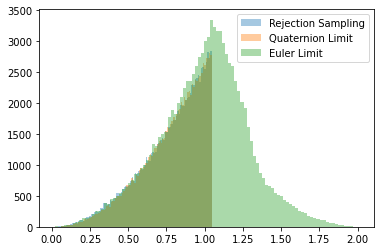

In [12]:
plt.hist(quat_angle(reject_sampler(100000)), bins=100, alpha=0.4, label="Rejection Sampling")
plt.hist(quat_angle(gaussian_sampler(100000)), bins=100, alpha=0.4, label="Quaternion Limit")
plt.hist(quat_angle(euler_sampler(100000)), bins=100, alpha=0.4, label="Euler Limit")
plt.legend()